In [1]:
import xarray as xr
import numpy as np
np.set_printoptions(threshold=sys.maxsize)


import metpy.calc as mpcalc
from metpy.units import units

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = '/project/s916/davidle/RCE-LND/analysis/RCE_300_3km_1006x1006_ALL_ens?/'

#2D fields
file='fldmean.nc'
all_2D = xr.open_mfdataset(path+file, concat_dim='ens').squeeze()
all_2D = xr.concat([all_2D, all_2D.isel(time=0)], dim='time').isel(time=slice(0,-1))

file='precip_stats/wd_freq_lnd.nc'
wd_freq_lnd = xr.open_mfdataset(path+file, concat_dim='ens').squeeze()
wd_freq_lnd = xr.concat([wd_freq_lnd, wd_freq_lnd.isel(time=0)], dim='time').isel(time=slice(0,-1))

#3D fields
file='fldmean_3D.nc'
all_3D = xr.open_mfdataset(path+file, concat_dim='ens').squeeze()
all_3D = xr.concat([all_3D, all_3D.isel(time=0)], dim='time').isel(time=slice(0,-1))


In [7]:
%%capture
#Landmask
path = '/scratch/snx3000/davidle/RCE-LND_new/RCE_300_3km_1006x1006_ALL_ens0/output/'
file='lffd2011032100c.nc'
all_const = xr.open_mfdataset(path+file).squeeze()

In [3]:
#Daily Variability

<Figure size 1440x720 with 0 Axes>

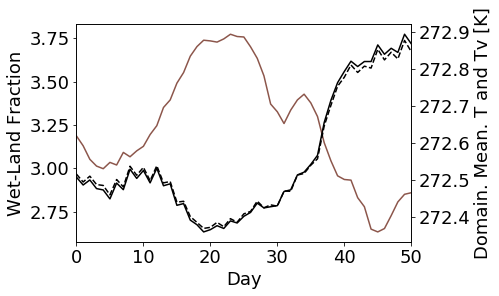

In [10]:
T = np.array(all_3D.resample(time='24h').mean().sel(ens=1).T.isel(level=lvl).isel(time=slice(99,None))) * units.kelvin
P = np.array(all_3D.resample(time='24h').mean().sel(ens=1).P.isel(level=lvl).isel(time=slice(99,None))) * units.pascals
RH = np.array(all_3D.resample(time='24h').mean().sel(ens=1).RELHUM.isel(level=lvl).isel(time=slice(99,None))) * units.percent

Tv = mpcalc.virtual_temperature(T, mpcalc.mixing_ratio_from_relative_humidity(RH, T, P))
#print(np.shape(Tv.resample(time='24h').mean()))

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18})
#plt.rcParams.update({'figure.autolayout': True})

fig, ax1 = plt.subplots()
plt.xlim(0,50)
plt.xlabel("Day")
plt.ylabel("Wet-Land Fraction")

plt.plot(wd_freq_lnd.sel(ens=1).isel(time=slice(95,None)).TOT_PREC.rolling(time=4).mean().shift(time=-4) * all_const.FR_LAND.mean() * 100, color='C5')

ax2 = ax1.twinx()
plt.plot(Tv - np.mean(Tv - T), color='k', linestyle='--')
plt.plot(T, color='k')
plt.ylabel("Domain. Mean. T and Tv [K]")

plt.savefig('Timeseries_wd-freq_T500.pdf')

In [11]:
np.mean(Tv - T)

0.380337 <Unit('kelvin')>

# Correlation

In [25]:
#Pearson correlation
corr = np.zeros(6)
sm_corr = np.zeros(6)
for e in range(6):
    T = np.array(all_3D.resample(time='24h').mean().sel(ens=e).T.isel(level=lvl).isel(time=slice(99,None))) * units.kelvin
    P = np.array(all_3D.resample(time='24h').mean().sel(ens=e).P.isel(level=lvl).isel(time=slice(99,None))) * units.pascals
    corr[e] = np.corrcoef(P,T)[1][0]
    sm_corr[e] = stats.spearmanr(P,T)[0]

In [31]:
print(corr[1])
print(np.tanh(np.mean(np.arctanh(corr))))


-0.9195091310085913
-0.44642754574821514


In [77]:
#Standardize timeseries 

prec_s = np.zeros((6,50))
T_s = np.zeros((6,50))

for e in range(6):
    p = wd_freq_lnd.sel(ens=e).isel(time=slice(95,None)).TOT_PREC.rolling(time=4).mean().shift(time=-4)[:50]
    t = all_3D.sel(ens=1).resample(time='24h').mean().isel(time=slice(99,None)).T[:50,lvl]

    prec_s[e,:]= ( p - p.mean()) / p.std()
    T_s[e,:] = ( t - t.mean() ) / t.std()

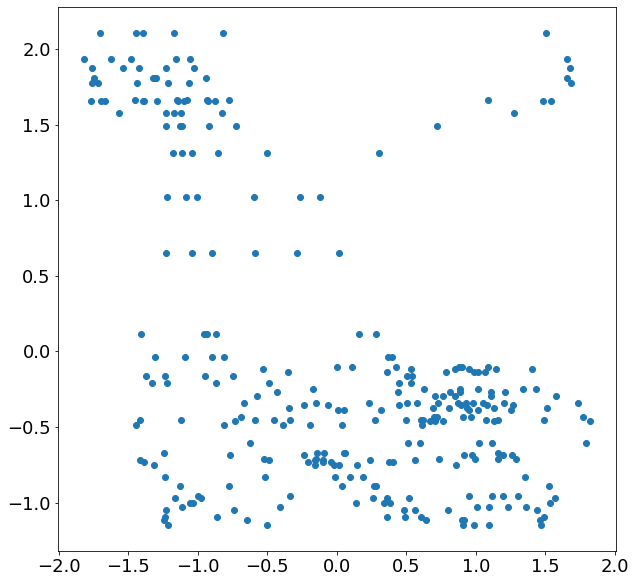

In [78]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 18})
#plt.rcParams.update({'figure.autolayout': True})

plt.scatter(prec_s , T_s)

In [79]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(prec_s.flatten(), T_s.flatten())

In [80]:
r_value

-0.45283920914304654

In [81]:
p_value

1.4211068796654958e-16

# T Profiles

In [38]:
%%capture
#dhourmean
path = '/project/s916/davidle/RCE-LND/analysis/RCE_300_3km_1006x1006_ALL_ens?/'
file='fldmean_3D.nc'
all_fldmean_3D= xr.open_mfdataset(path+file, concat_dim='ens').isel(time=slice(2400,None)).squeeze()

path = '/project/s916/davidle/RCE-LND/analysis/RCE_300_3km_1006x1006_SMALL_ens?/'
file='fldmean_3D.nc'
small_fldmean_3D= xr.open_mfdataset(path+file, concat_dim='ens').isel(time=slice(2400,None)).squeeze()

In [39]:
all_Tv = mpcalc.virtual_temperature(all_fldmean_3D.T, mpcalc.mixing_ratio_from_relative_humidity(all_fldmean_3D.RELHUM, all_fldmean_3D.T, all_fldmean_3D.P))
small_Tv = mpcalc.virtual_temperature(small_fldmean_3D.T, mpcalc.mixing_ratio_from_relative_humidity(small_fldmean_3D.RELHUM, small_fldmean_3D.T, small_fldmean_3D.P))

In [89]:
#Resampling the 
dTv = np.zeros((36,74))
dT= np.zeros((36,74))
for i in range(6):
    for j in range(6):
        dTv[i*j,:] =  small_Tv[i,:,:].mean(axis=0) - all_Tv[j,:,:].mean(axis=0)
        dT[i*j,:] =  small_fldmean_3D.T[i,:,:].mean(axis=0) - all_fldmean_3D.T[j,:,:].mean(axis=0)

dTv_mean = np.array(small_Tv.mean(axis=(0,1)) - all_Tv.mean(axis=(0,1)))
dT_mean = np.array(small_fldmean_3D.T.mean(axis=(0,1)) - all_fldmean_3D.T.mean(axis=(0,1)))

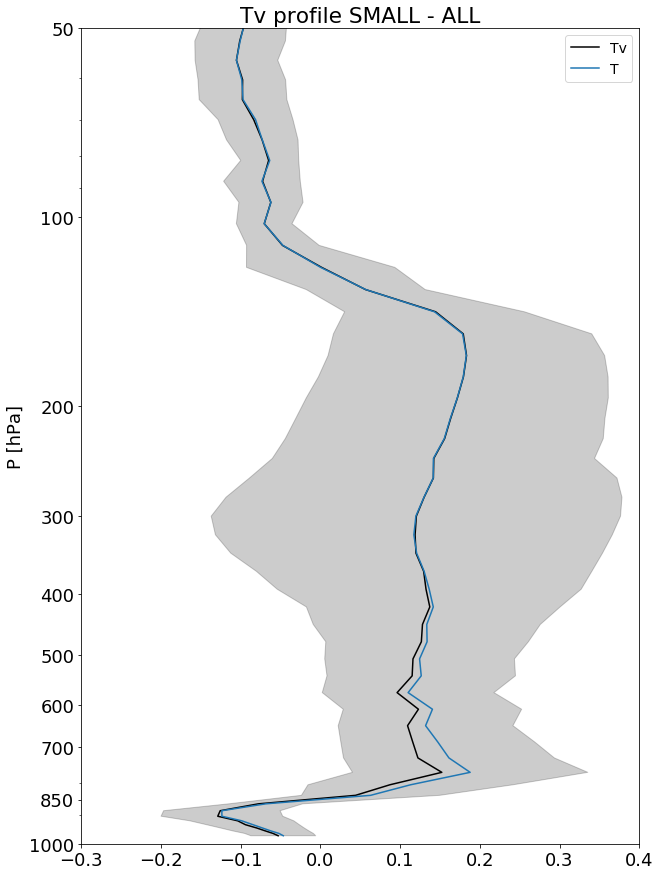

In [92]:
#Virtual Temperature
plt.figure(figsize=(10, 15))
plt.rcParams.update({'font.size': 18})

plt.ylabel('P [hPa]')
plt.yscale('log')
plt.ylim(50,1000)
plt.yticks([1000, 850, 700, 600, 500, 400, 300, 200, 100, 50], ['1000', '850', '700', '600', '500', '400', '300', '200', '100', '50'])

plt.title('Tv profile SMALL - ALL')
plt.plot( dTv_mean, all_fldmean_3D.P.mean(axis=(0,1)) / 100, label='Tv', color='k')
plt.plot( dT_mean, all_fldmean_3D.P.mean(axis=(0,1)) / 100, label='T' )

plt.fill_betweenx(all_fldmean_3D.P.mean(axis=(0,1)) / 100, dT_mean + np.std(dT, axis=0), dT_mean - np.std(dT, axis=0), alpha=0.2, color='k')

#plt.axvline(x=0, color='k', alpha=0.5)

plt.legend(loc='best',  fontsize='14')
plt.xlim(-0.3,0.4)
plt.gca().invert_yaxis()

plt.savefig('T_profile.pdf')